In [1]:
import pandas as pd
from collections import Counter
import torch
import torch.nn.functional as F

In [2]:
CUTOFF = 50

In [3]:
df = pd.read_csv('data/parsed.csv')

In [4]:
df

,Unnamed: 0,from,text,forwarded_from,length
0,38,Илюша,"Дети, не забудьте пожалуйста бабулю с дедулей ...",NaN,74
1,39,Елисей,Ок,NaN,2
2,43,Илюша,В самолете,NaN,10
3,44,Илюша,Сижу в бизнес классе,NaN,20
4,46,Таня,"Приятного полёта, солнце мое.",NaN,29
...,...,...,...,...,...
8820,12955,Илюша,"Не, ставь класс",NaN,15
8821,12956,Мама,Ставим класс!,NaN,13
8822,12958,Папа,Всем смотреть!!!!!!,NaN,19
8823,12959,Алёна,Я видела,NaN,8


In [5]:
letters = set()
for i in df['text']:
    for j in i:
        letters.add(j) 

In [6]:
letters

{'\n',
 ' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 '\\',
 ']',
 '^',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '}',
 '~',
 '\xa0',
 '¡',
 '«',
 '°',
 '²',
 '»',
 'Ё',
 'А',
 'Б',
 'В',
 'Г',
 'Д',
 'Е',
 'Ж',
 'З',
 'И',
 'Й',
 'К',
 'Л',
 'М',
 'Н',
 'О',
 'П',
 'Р',
 'С',
 'Т',
 'У',
 'Ф',
 'Х',
 'Ц',
 'Ч',
 'Ш',
 'Щ',
 'Ы',
 'Ь',
 'Э',
 'Ю',
 'Я',
 'а',
 'б',
 'в',
 'г',
 'д',
 'е',
 'ж',
 'з',
 'и',
 'й',
 'к',
 'л',
 'м',
 'н',
 'о',
 'п',
 'р',
 'с',
 'т',
 'у',
 'ф',
 'х',
 'ц',
 'ч',
 'ш',
 'щ',
 'ъ',
 'ы',
 'ь',
 'э',
 'ю',
 'я',
 'ё',
 '\u2

In [7]:
all_text = ''
for i in df['text']:
    all_text += i.lower()
counter = pd.Series(Counter(all_text)).sort_values()

In [8]:
import string
alp='абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
counter_rus = counter[counter.index.to_series().isin(list(alp))]

<AxesSubplot:>

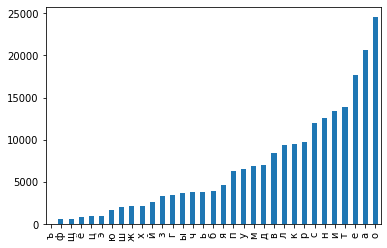

In [9]:
counter_rus.plot(kind='bar')

In [10]:
counter_rus

ъ       38
ф      630
щ      645
ё      831
ц      988
э     1036
ю     1703
ш     2079
ж     2199
х     2214
й     2649
з     3366
г     3431
ы     3733
ч     3798
ь     3843
б     3924
я     4617
п     6355
у     6606
м     6923
д     7041
в     8401
л     9361
к     9459
р     9788
с    11991
н    12535
и    13465
т    13841
е    17672
а    20666
о    24523
dtype: int64

In [11]:
counter = counter[counter > CUTOFF]

In [12]:
counter_list = counter.index.to_list()

In [13]:
class Tokenizator:
    def __init__(self, tokens: list, max_length: int):
        self.num_tokens = len(tokens)
        self.tokens = tokens
        self.max_length = max_length
        
    def tokenize(self, text: str) -> torch.Tensor:
        res_text = []
        
        if len(text) > self.max_length:
            text = text[:self.max_length]
        
        for i in text:
            if i not in self.tokens:
                continue
            res_letter = [0]*self.num_tokens
            res_letter[self.tokens.index(i)] = 1
            res_text.append(res_letter)
            
        difference = self.max_length - len(res_text)
        for i in range(difference):
            res_text.append([0]*self.num_tokens)
            
        return torch.Tensor(res_text)

In [14]:
tokenizator = Tokenizator(counter_list, 10)

In [15]:
tokenizator.tokenize('мамамамамамамамммаммама').shape

torch.Size([10, 98])

In [16]:
df_tokenized = df

In [17]:
# def index_of_sender(sender):
#     message_index = []
#     counter = -1
#     for j in df_tokenized['from']:
#         counter += 1
#         if j == sender:
#             message_index.append(counter)
#     return message_index

In [18]:
# df_tokenized = df_tokenized.drop(index_of_sender('Imitation Bot'))

In [19]:
df_tokenized['from'].unique()

array(['Илюша', 'Елисей', 'Таня', 'Алёна', 'Мама', 'Папа', 'Лизка',
       'Бабуля💘', 'ДедулЯ', nan, 'Imitation Bot', 'Лука'], dtype=object)

In [20]:
df_tokenized = df_tokenized.drop(['forwarded_from'], axis=1)

In [21]:
df_tokenized

,Unnamed: 0,from,text,length
0,38,Илюша,"Дети, не забудьте пожалуйста бабулю с дедулей ...",74
1,39,Елисей,Ок,2
2,43,Илюша,В самолете,10
3,44,Илюша,Сижу в бизнес классе,20
4,46,Таня,"Приятного полёта, солнце мое.",29
...,...,...,...,...
8820,12955,Илюша,"Не, ставь класс",15
8821,12956,Мама,Ставим класс!,13
8822,12958,Папа,Всем смотреть!!!!!!,19
8823,12959,Алёна,Я видела,8


In [107]:
text = list(df_tokenized['text'])
for i in text:   
    df_tokenized['tokenized_text'][text.index(i)] = tokenizator.tokenize(i)

C:\Users\zahar\AppData\Local\Temp\ipykernel_5464\981322810.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokenized['tokenized_text'][text.index(i)] = tokenizator.tokenize(i)


In [114]:
d = {'col1': [1, 2], 'col2': [3, 4]}
df1 = pd.DataFrame(data=d)

In [115]:
df1

,col1,col2
0,1,3
1,2,4


In [117]:
df1['col2'][0] = listtokenizator.tokenize(text[0])

3

In [108]:
df_tokenized

,Unnamed: 0,from,text,length,tokenized_text,tokenized_sender
0,38,Илюша,"Дети, не забудьте пожалуйста бабулю с дедулей ...",74,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",0
1,39,Елисей,Ок,2,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",1
2,43,Илюша,В самолете,10,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",0
3,44,Илюша,Сижу в бизнес классе,20,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",0
4,46,Таня,"Приятного полёта, солнце мое.",29,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",2
...,...,...,...,...,...,...
8820,12955,Илюша,"Не, ставь класс",15,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",0
8821,12956,Мама,Ставим класс!,13,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",0
8822,12958,Папа,Всем смотреть!!!!!!,19,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",0
8823,12959,Алёна,Я видела,8,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",0


In [105]:
unique_senders = list(df_tokenized['from'].unique())
senders = list(df_tokenized['from'])
for i in senders:
    for j in unique_senders:
        if i == j:
            df_tokenized['tokenized_sender'][senders.index(i)] = unique_senders.index(i)

C:\Users\zahar\AppData\Local\Temp\ipykernel_5464\974734494.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokenized['tokenized_sender'][senders.index(i)] = unique_senders.index(i)


In [104]:
len(senders)

8825

In [99]:
print(list(df_tokenized['from']))

['Илюша', 'Елисей', 'Илюша', 'Илюша', 'Таня', 'Таня', 'Таня', 'Илюша', 'Илюша', 'Таня', 'Таня', 'Алёна', 'Алёна', 'Илюша', 'Алёна', 'Илюша', 'Алёна', 'Илюша', 'Мама', 'Елисей', 'Таня', 'Елисей', 'Илюша', 'Таня', 'Папа', 'Алёна', 'Елисей', 'Папа', 'Алёна', 'Папа', 'Таня', 'Илюша', 'Таня', 'Илюша', 'Алёна', 'Алёна', 'Таня', 'Таня', 'Алёна', 'Елисей', 'Алёна', 'Елисей', 'Мама', 'Елисей', 'Мама', 'Лизка', 'Елисей', 'Мама', 'Елисей', 'Елисей', 'Лизка', 'Мама', 'Мама', 'Елисей', 'Лизка', 'Лизка', 'Елисей', 'Алёна', 'Елисей', 'Мама', 'Илюша', 'Мама', 'Илюша', 'Алёна', 'Алёна', 'Илюша', 'Папа', 'Таня', 'Мама', 'Алёна', 'Папа', 'Алёна', 'Таня', 'Мама', 'Таня', 'Таня', 'Алёна', 'Елисей', 'Мама', 'Папа', 'Алёна', 'Мама', 'Папа', 'Мама', 'Мама', 'Папа', 'Мама', 'Илюша', 'Бабуля💘', 'Таня', 'Таня', 'Мама', 'Илюша', 'Алёна', 'Илюша', 'Таня', 'Илюша', 'Алёна', 'Таня', 'Мама', 'Илюша', 'Таня', 'Мама', 'Бабуля💘', 'Папа', 'Мама', 'Таня', 'Бабуля💘', 'Лизка', 'Алёна', 'Бабуля💘', 'Таня', 'Таня', 'Папа', 'Ил

In [103]:
df_tokenized

,Unnamed: 0,from,text,length,tokenized_text,tokenized_sender
0,38,Илюша,"Дети, не забудьте пожалуйста бабулю с дедулей ...",74,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",0
1,39,Елисей,Ок,2,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",1
2,43,Илюша,В самолете,10,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",0
3,44,Илюша,Сижу в бизнес классе,20,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",0
4,46,Таня,"Приятного полёта, солнце мое.",29,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",2
...,...,...,...,...,...,...
8820,12955,Илюша,"Не, ставь класс",15,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",0
8821,12956,Мама,Ставим класс!,13,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",0
8822,12958,Папа,Всем смотреть!!!!!!,19,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",0
8823,12959,Алёна,Я видела,8,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",0
